# For the revision
## compare the manifods
### TF version 2.0.0

In [1]:
import os
# # force CPU for inference
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

from tensorflow.keras.models import load_model
import pandas as pd
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import Callback
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats import norm

import tikzplotlib

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

%matplotlib inline

### load the 12RES300 model

In [2]:
model = load_model('12_Block_Nets/FPV_ANN_tabulated_Standard_300.h5')
# model = load_model('../tmp/calc_100_3_3_cbrt.h5', custom_objects={'coeff_r2':coeff_r2})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 300)          1200        input_1[0][0]                    
__________________________________________________________________________________________________
res1_0_branch2a (Dense)         (None, 300)          90300       dense[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 300)          0           res1_0_branch2a[0][0]            
______________________________________________________________________________________________

### helper functions

In [3]:
def read_h5_data(fileName, input_features, labels):
    df = pd.read_hdf(fileName)
#     df = df[df['f']<0.45]
#     for i in range(5):
#         pv_101=df[df['pv']==1]
#         pv_101['pv']=pv_101['pv']+0.002*(i+1)
#         df = pd.concat([df,pv_101])
    
    input_df=df[input_features]
    in_scaler = data_scaler()
    input_np = in_scaler.fit_transform(input_df.values,'std2')

    label_df=df[labels].clip(0)
#     if 'PVs' in labels:
#       label_df['PVs']=np.log(label_df['PVs']+1)
    out_scaler = data_scaler()
    label_np = out_scaler.fit_transform(label_df.values,'cbrt_std')

    return input_np, label_np, df, in_scaler, out_scaler

In [4]:

class data_scaler(object):
    def __init__(self):
        self.norm = None
        self.norm_1 = None
        self.std = None
        self.case = None
        self.scale = 1
        self.bias = 1e-20
#         self.bias = 1


        self.switcher = {
            'min_std': 'min_std',
            'std2': 'std2',
            'std_min':'std_min',
            'min': 'min',
            'no':'no',
            'log': 'log',
            'log_min':'log_min',
            'log_std':'log_std',
            'log2': 'log2',
            'sqrt_std': 'sqrt_std',
            'cbrt_std': 'cbrt_std',
            'nrt_std':'nrt_std',
            'tan': 'tan'
        }

    def fit_transform(self, input_data, case):
        self.case = case
        if self.switcher.get(self.case) == 'min_std':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'std2':
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'min':
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.norm = MinMaxScaler()
            out = self.norm.fit_transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'log2':
            self.norm = MinMaxScaler()
            self.std = StandardScaler()
            out = self.norm.fit_transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            self.std = StandardScaler()
            out = self.std.fit_transform(out)

        if self.switcher.get(self.case) == 'tan':
            self.norm = MaxAbsScaler()
            self.std = StandardScaler()
            out = self.std.fit_transform(input_data)
            out = self.norm.fit_transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def transform(self, input_data):
        if self.switcher.get(self.case) == 'min_std':
            out = self.norm.transform(input_data)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.norm.transform(out)

        if self.switcher.get(self.case) == 'log_std':
            out = - np.log(np.asarray(input_data / self.scale) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'log2':
            out = self.norm.transform(input_data)
            out = np.log(np.asarray(out) + self.bias)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = np.sqrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'cbrt_std':
            out = np.cbrt(np.asarray(input_data / self.scale))
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'nrt_std':
            out = np.power(np.asarray(input_data / self.scale),1/4)
            out = self.std.transform(out)

        if self.switcher.get(self.case) == 'tan':
            out = self.std.transform(input_data)
            out = self.norm.transform(out)
            out = np.tan(out / (2 * np.pi + self.bias))

        return out

    def inverse_transform(self, input_data):

        if self.switcher.get(self.case) == 'min_std':
            out = self.std.inverse_transform(input_data)
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'std2':
            out = self.std.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'std_min':
            out = self.norm.inverse_transform(input_data)
            out = self.std.inverse_transform(out)

        if self.switcher.get(self.case) == 'min':
            out = self.norm.inverse_transform(input_data)

        if self.switcher.get(self.case) == 'no':
            out = input_data

        if self.switcher.get(self.case) == 'log_min':
            out = self.norm.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log_std':
            out = self.std.inverse_transform(input_data)
            out = (np.exp(-out) - self.bias) * self.scale

        if self.switcher.get(self.case) == 'log2':
            out = self.std.inverse_transform(input_data)
            out = np.exp(out) - self.bias
            out = self.norm.inverse_transform(out)

        if self.switcher.get(self.case) == 'sqrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,2) * self.scale

        if self.switcher.get(self.case) == 'cbrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,3) * self.scale

        if self.switcher.get(self.case) == 'nrt_std':
            out = self.std.inverse_transform(input_data)
            out = np.power(out,4) * self.scale

        if self.switcher.get(self.case) == 'tan':
            out = (2 * np.pi + self.bias) * np.arctan(input_data)
            out = self.norm.inverse_transform(out)
            out = self.std.inverse_transform(out)

        return out

In [5]:
labels =  ['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']

print(labels)

input_features=['f','zeta','pv']

# read in the data
x_input, y_label, df, in_scaler, out_scaler = read_h5_data('data/tables_of_fgm.h5',input_features=input_features, labels = labels)

['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'CH3', 'CH4', 'CO', 'CO2', 'CH2O', 'N2', 'T', 'PVs']


## make the scatter plots as: $(y_{pred}-y_{true}) / y_{true}$

In [6]:
# firs: train test split

x_train, x_test, y_train, y_test = train_test_split(x_input,y_label, test_size=0.01)

x_test_df = pd.DataFrame(in_scaler.inverse_transform(x_test),columns=input_features)
y_test_df = pd.DataFrame(out_scaler.inverse_transform(y_test),columns=labels)

# PREDICT
predict_val = model.predict(x_test,batch_size=1024*8)
predict_df = pd.DataFrame(out_scaler.inverse_transform(predict_val), columns=labels)

df_test=pd.concat([x_test_df,y_test_df],axis=1)
df_pred=pd.concat([x_test_df,predict_df],axis=1)

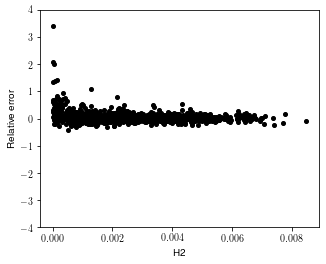

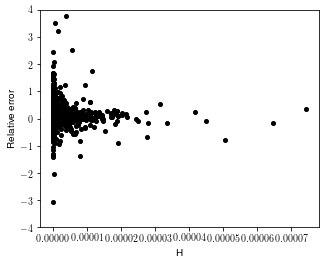

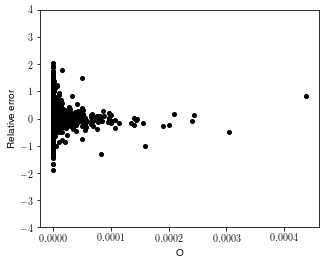

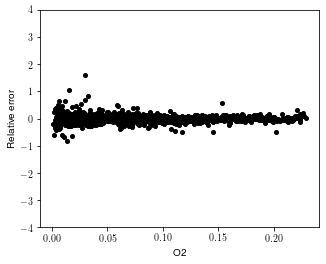

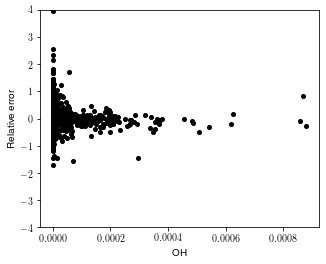

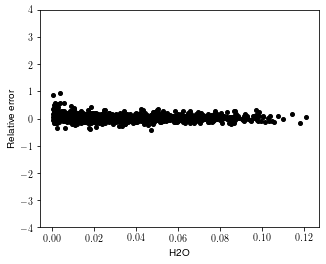

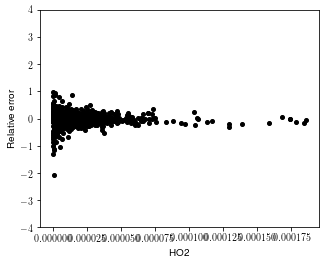

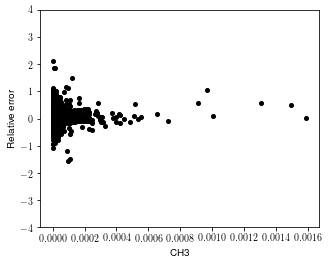

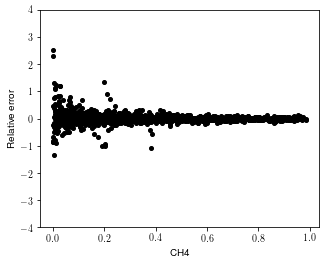

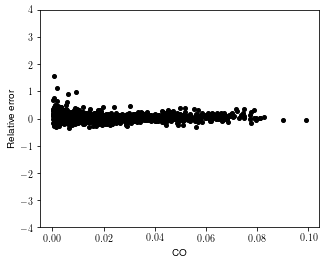

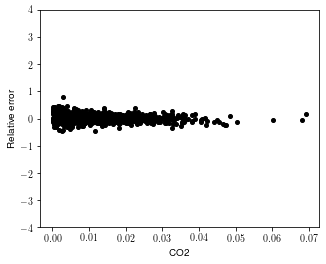

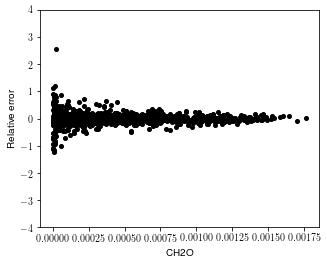

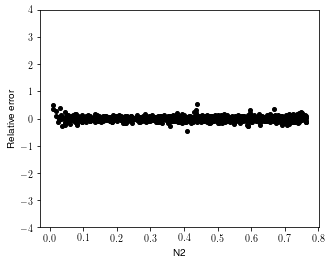

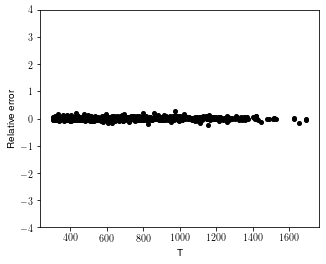

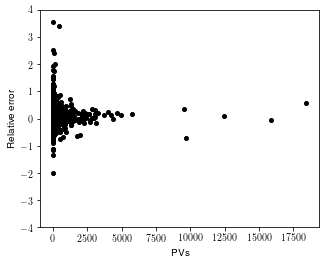

In [12]:
df_test_show=df_test[df_test['PVs']>5].sample(frac=0.1)
#df_test_show1 = df_test[df_test.PVs>2000].sample(frac=0.5)

#df_test_show = pd.concat([df_test_show,df_test_show1])
df_pred_show=df_pred.iloc[df_test_show.index]

SMALL = 1e-20

for sp in labels:
    plt.figure(figsize=(5,4))
    x=df_test_show[sp].values
    y=df_pred_show[sp].values
    if sp is 'PVs':
        plt.plot(y,(((x-y)+SMALL)/(y+SMALL) -SMALL)*100,'ko',markersize=4)
    else:
        plt.plot(y,(((x-y))/(y) )*100,'ko',markersize=4)
    #plt.plot(y,'ro',markersize=4)
    plt.xlabel(sp)
    plt.ylabel('Relative error')
    #plt.yscale('log')
    plt.ylim((-4,4))
    ax=plt.gca()
    #ax.set_aspect('equal')
    #tikzplotlib.save("scatter_plots_revision/%s_rel_errors.tex" % sp)
# for sp in labels:
#     plt.figure()
#     x=df_test_show[sp]
#     y=df_pred_show[sp]
#     plt.scatter(((x-y)+SMALL)/(y+SMALL),y,c='k',s=1.5)
#     ax=plt.gca()
#     plt.title(sp)
#     #ax.set_aspect('equal')
#     #ax.get_xaxis().set_visible(False)
#     #ax.get_yaxis().set_visible(False)
#     #ax.axis('off')
#     #plt.savefig('scatter_plots/{0}_r2.eps'.format(sp),format='eps',bbox_inches='tight', pad_inches=0)

## plot the manifolds

In [8]:
y_df = pd.DataFrame(out_scaler.inverse_transform(y_label),columns=labels)
x_df = pd.DataFrame(in_scaler.inverse_transform(x_input),columns=input_features)

In [9]:
index_zeta0 =  x_df[(x_df.zeta < 0.01) ].index


In [10]:
x_df_zeta0 = x_df.iloc[index_zeta0]
y_df_zeta0 = y_df.iloc[index_zeta0]

In [11]:
x_df_zeta0

,f,zeta,pv
0,0.000,-5.551115e-17,0.0
1,0.002,-5.551115e-17,0.0
2,0.004,-5.551115e-17,0.0
3,0.006,-5.551115e-17,0.0
4,0.008,-5.551115e-17,0.0
...,...,...,...
2505496,0.992,-5.551115e-17,1.0
2505497,0.994,-5.551115e-17,1.0
2505498,0.996,-5.551115e-17,1.0
2505499,0.998,-5.551115e-17,1.0


In [13]:
def plot_2d(data):
    
    data = data.values.reshape(501,501)
    
    data=data[:,0:int(501*0.3)]
    
    data_max = data.max()
    
    plt.figure(figsize=(10,10))
    plt.imshow(data,cmap='jet',origin='lower')
    plt.contour(data, levels=np.linspace(0,data_max,20),colors='k',linewidths=0.7)
    #plt.xlim((0,int(501*0.3)))
    ax=plt.gca()
    ax.set_aspect('equal')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    ax.axis('off')
    ax.margins(0,0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    ax.set_aspect(0.3)
    #plt.margins(0,0)

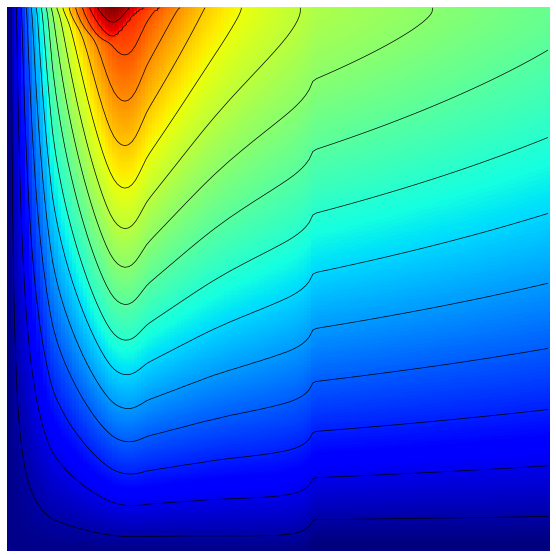

In [14]:

plot_2d(y_df_zeta0['T'])
# plt.savefig("figs/T_original.pdf",bbox_inches = 'tight',pad_inches = 0)

## predict the manifold

In [15]:
# transform input
x_zeta0= in_scaler.transform(x_df_zeta0)

y_predict_zeta0 = model.predict(x_zeta0,batch_size=8*1024)

In [19]:
y_predict_df = pd.DataFrame(out_scaler.inverse_transform(y_predict_zeta0),columns=labels)
y_predict_df

,H2,H,O,O2,OH,H2O,HO2,CH3,CH4,CO,CO2,CH2O,N2,T,PVs
0,7.104438e-21,1.908497e-16,1.453685e-16,2.321243e-01,8.033071e-13,-6.134050e-10,1.849144e-12,4.108384e-13,-2.397827e-10,-4.224540e-11,6.226078e-11,5.642989e-14,7.663853e-01,299.016937,-5.455046e-07
1,1.206078e-12,-4.523568e-15,-7.658469e-13,2.328827e-01,-6.170258e-14,1.878448e-10,5.002364e-17,-6.422447e-14,2.022861e-03,-2.723364e-11,1.198874e-12,9.747545e-15,7.674131e-01,301.292542,5.813664e-07
2,-6.684823e-14,1.629469e-18,6.841464e-16,2.318990e-01,2.738725e-14,3.550391e-12,6.011111e-18,2.111601e-14,4.066329e-03,-1.561093e-10,1.551004e-12,-7.695958e-15,7.652206e-01,300.451263,-1.656031e-07
3,8.046573e-13,3.240335e-16,5.603022e-14,2.314326e-01,3.706229e-14,2.849534e-14,2.256560e-14,1.831210e-13,5.992903e-03,-1.781459e-10,-5.012449e-13,3.784168e-14,7.646435e-01,300.306183,-3.248193e-07
4,1.799049e-11,1.570546e-15,1.835637e-13,2.305773e-01,2.232206e-13,3.013609e-11,5.393482e-13,1.123807e-12,7.960183e-03,-4.795033e-11,-7.965440e-13,7.371769e-13,7.620578e-01,300.360596,-3.435422e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250996,8.317291e-05,5.292363e-10,8.699551e-12,1.923684e-05,2.109795e-10,1.097758e-03,8.444933e-10,1.719653e-07,9.907516e-01,9.368777e-04,4.129153e-04,1.387208e-07,6.054656e-03,310.595490,1.276448e-03
250997,6.249609e-05,3.982087e-10,4.763362e-12,1.446554e-05,1.537643e-10,8.279627e-04,6.111136e-10,1.282154e-07,9.929672e-01,7.037136e-04,3.114726e-04,1.021356e-07,4.554839e-03,307.902679,1.165530e-03
250998,4.167548e-05,2.728150e-10,2.186644e-12,9.551895e-06,9.797963e-11,5.567516e-04,3.977753e-10,8.731057e-08,9.956132e-01,4.712633e-04,2.098787e-04,6.718187e-08,3.079081e-03,305.424713,9.992396e-04
250999,2.047552e-05,1.206636e-10,2.980193e-13,5.113238e-06,4.981732e-11,2.793248e-04,2.179362e-10,4.333371e-08,9.984864e-01,2.334772e-04,1.051384e-04,3.473806e-08,1.531116e-03,303.367584,3.930746e-04


In [63]:
# # shif colormap function
# import numpy as np
# import matplotlib
# import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import AxesGrid

# def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
#     '''
#     Function to offset the "center" of a colormap. Useful for
#     data with a negative min and positive max and you want the
#     middle of the colormap's dynamic range to be at zero.

#     Input
#     -----
#       cmap : The matplotlib colormap to be altered
#       start : Offset from lowest point in the colormap's range.
#           Defaults to 0.0 (no lower offset). Should be between
#           0.0 and `midpoint`.
#       midpoint : The new center of the colormap. Defaults to 
#           0.5 (no shift). Should be between 0.0 and 1.0. In
#           general, this should be  1 - vmax / (vmax + abs(vmin))
#           For example if your data range from -15.0 to +5.0 and
#           you want the center of the colormap at 0.0, `midpoint`
#           should be set to  1 - 5/(5 + 15)) or 0.75
#       stop : Offset from highest point in the colormap's range.
#           Defaults to 1.0 (no upper offset). Should be between
#           `midpoint` and 1.0.
#     '''
#     cdict = {
#         'red': [],
#         'green': [],
#         'blue': [],
#         'alpha': []
#     }

#     # regular index to compute the colors
#     reg_index = np.linspace(start, stop, 257)

#     # shifted index to match the data
#     shift_index = np.hstack([
#         np.linspace(0.0, midpoint, 128, endpoint=False), 
#         np.linspace(midpoint, 1.0, 129, endpoint=True)
#     ])

#     for ri, si in zip(reg_index, shift_index):
#         r, g, b, a = cmap(ri)

#         cdict['red'].append((si, r, r))
#         cdict['green'].append((si, g, g))
#         cdict['blue'].append((si, b, b))
#         cdict['alpha'].append((si, a, a))

#     newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
#     plt.register_cmap(cmap=newcmap)

#     return newcmap

In [76]:
# shifted_RdBu = shiftedColorMap(matplotlib.cm.RdBu, start=0, midpoint=100.0, stop=200, name='shifted')

### plot the predicted manifold

In [45]:
y_predict_df['PVs_diff'] = (y_df_zeta0['PVs'].values - y_predict_df['PVs'].values) #/ y_df_zeta0['PVs'].values
y_predict_df['T_diff'] = (y_df_zeta0['T'].values - y_predict_df['T'].values) 


from matplotlib import colors
# colors.DivergingNorm( vcenter=0.0)

def plot_2d_error(data,factor):
    
    
    
    data = data.values.reshape(501,501)
    
    data=data[:,0:int(501*0.3)]
    
    data_max = data.max()
    data_min = data.min()
    
    #colors.DivergingNorm(vmin=data_min, vcenter=0., vmax=data_max)
    
    plt.figure(figsize=(10,10))
    plt.imshow(data,cmap='RdBu',origin='lower',vmin=-data_max*factor, vmax=data_max*factor)
#    plt.imshow(data,cmap='RdBu',origin='lower',vmin=0, vmax=factor)
#    plt.imshow(data,cmap='RdBu',origin='lower')
#    plt.colorbar()
    
    #plt.clim(data_min,data_max)
    #plt.contour(data, levels=np.linspace(0,data_max,20),colors='k',linewidths=0.7)
    #plt.xlim((0,int(501*0.3)))

    
    ax=plt.gca()
    ax.set_aspect('equal')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    
    ax.axis('off')
    ax.margins(0,0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    ax.set_aspect(0.3)
    #plt.margins(0,0)


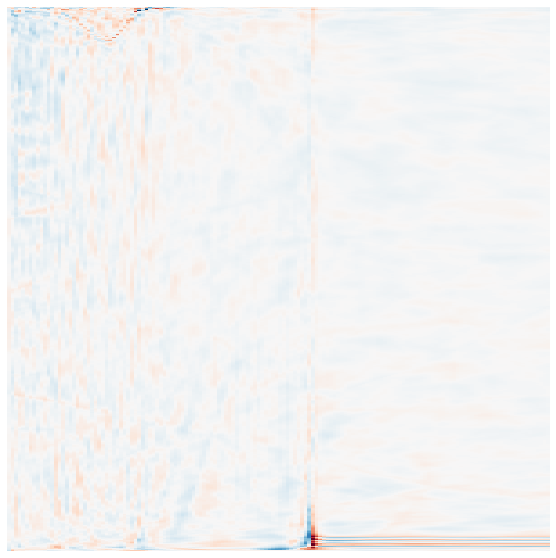

In [46]:

plot_2d_error(y_predict_df['T_diff']/y_predict_df['T'],0.7)
#plt.savefig("figs/PVs_manifold_diff.pdf",bbox_inches = 'tight',pad_inches = 0)

In [116]:
y_predict_df['T_diff'].max() * 0.5

20.47044921874999

In [44]:
plt.colormaps()

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 'afmhot',
 'afmhot_r',
 'autumn',
 'autumn_r',
 'binary',
 'binary_r',
 'bone',
 'bone_r',
 'brg',
 'brg_r',
 'bwr',
 'bwr_r',
 'cividis',
 'cividis_r',
 'cool',
 'cool_r',
 'co

In [23]:
150/20000

0.0075